# Imports und Logging

In [1]:
import logging
import os
import sys

import pandas as pd
import sqlite3


import geopandas
import numpy as np
import math
import importlib
import re

import doctest

import matplotlib.pyplot as plt
#import matplotlib.dates as mdates

import matplotlib

import matplotlib.patches as mpatches

#import matplotlib.gridspec as gridspec

#from matplotlib import cm
#from matplotlib.colors import ListedColormap
#import matplotlib.font_manager as font_manager
#import matplotlib.patheffects as path_effects

#import contextily as cx

import pickle

import xml.etree.ElementTree as ET

logger = logging.getLogger('FW Bad Salzuflen')  

logFileName= r"FW Bad Salzuflen.log" 

loglevel = logging.DEBUG
logging.basicConfig(filename=logFileName
                        ,filemode='w'
                        ,level=loglevel
                        ,format="%(asctime)s ; %(name)-60s ; %(levelname)-7s ; %(message)s")    

fileHandler = logging.FileHandler(logFileName)     

logger.addHandler(fileHandler)

consoleHandler = logging.StreamHandler()
consoleHandler.setFormatter(logging.Formatter("%(levelname)-7s ; %(message)s"))
consoleHandler.setLevel(logging.INFO)
logger.addHandler(consoleHandler)

# IN

In [2]:
dbFilename="FW Bad Salzuflen"

# Modell und Ergebnisse lesen

In [3]:
try:
    from PT3S import dxAndMxHelperFcts
except:
    import dxAndMxHelperFcts

In [4]:
 importlib.reload(dxAndMxHelperFcts)   

<module 'dxAndMxHelperFcts' from 'c:\\users\\wolters\\3s\\pt3s\\dxAndMxHelperFcts.py'>

In [5]:
m=dxAndMxHelperFcts.readDxAndMx(dbFile=os.path.join('.',dbFilename+'.db3'))

## Gruppen

In [6]:
dfLAYR=m.dfLAYR

In [7]:
dfLAYR.head()

pk                   tk  LFDNR          NAME  AnzDerObjekteInGruppe  AnzDerObjekteDesTypsInGruppe  TYPE                   ID  NrDesObjektesDesTypsInGruppe  NrDesObjektesInGruppe  GruppenDesObjektsAnz            GruppenDesObjektsNamen
0  4615316810435331673  4615316810435331673    1.0  Blocksymbole                      4                             4  CONT  4825472149394202907                             1                      1                     2  [Blocksymbole, Gebiet 1 HoffLoh]
1  4615316810435331673  4615316810435331673    1.0  Blocksymbole                      4                             4  CONT  5312839466984016002                             2                      2                     2  [Blocksymbole, Gebiet 1 HoffLoh]
2  4615316810435331673  4615316810435331673    1.0  Blocksymbole                      4                             4  CONT  5483797063333391933                             3                      3                     2   [Blocksymbole, Gebiet 2 Staats]
3  4615316810435331673  4615316810435331673    1.0  Blocksymbole                      4                             4  CONT  5603411125000654144                             4                      4                     2   [Blocksymbole, Gebiet 3 Ziegel]
4  5037484777939939678  5037484777939939678    2.0   BlockKreise                      4                             4  CIRC  4854559580991530594                             1                      1                     1                     [BlockKreise]

In [8]:
dfUpd=dfLAYR[dfLAYR['TYPE'].isin(['KNOT'])].head()[['TYPE','ID']]
dfUpd

TYPE                   ID
8   KNOT  4612377696077690262
9   KNOT  4614389594913984571
10  KNOT  4632022387105447068
11  KNOT  4637237044430048855
12  KNOT  4643776603804431404

In [9]:
xk=dfLAYR[dfLAYR['NAME'].isin(['Test'])]['tk'].iloc[0]

In [10]:
#sorted(dfLAYR['NAME'].unique())

In [11]:
dfUpd['table']='LAYR'

In [12]:
dfUpd['attrib']='OBJS'

In [13]:
dfUpd['xk']='tk'

In [14]:
dfUpd['xkValue']=xk

In [15]:
dfUpd['attribValue']=dfUpd.apply(lambda row: "{:s}~{:s}\t".format(row['TYPE'],row['ID']).encode('utf-8'),axis=1)

In [16]:
dfUpd

TYPE                   ID table attrib  xk              xkValue                    attribValue
8   KNOT  4612377696077690262  LAYR   OBJS  tk  5423055592859548388  b'KNOT~4612377696077690262\t'
9   KNOT  4614389594913984571  LAYR   OBJS  tk  5423055592859548388  b'KNOT~4614389594913984571\t'
10  KNOT  4632022387105447068  LAYR   OBJS  tk  5423055592859548388  b'KNOT~4632022387105447068\t'
11  KNOT  4637237044430048855  LAYR   OBJS  tk  5423055592859548388  b'KNOT~4637237044430048855\t'
12  KNOT  4643776603804431404  LAYR   OBJS  tk  5423055592859548388  b'KNOT~4643776603804431404\t'

In [17]:
dfUpd.dtypes

TYPE           object
ID             object
table          object
attrib         object
xk             object
xkValue        object
attribValue    object
dtype: object

In [18]:
dfUpd2=dfUpd.groupby(by=['xkValue']).agg({'xkValue': 'first'
                                   ,'table': 'first'
                                   ,'attrib': 'first'
                                   ,'xk': 'first'
                                   , 'attribValue': 'sum'}).reset_index(drop=True)
dfUpd2['attribValue']=dfUpd2['attribValue'].apply(lambda x: x.rstrip())
dfUpd2

xkValue table attrib  xk                                                                                                                          attribValue
0  5423055592859548388  LAYR   OBJS  tk  b'KNOT~4612377696077690262\tKNOT~4614389594913984571\tKNOT~4632022387105447068\tKNOT~4637237044430048855\tKNOT~4643776603804431404'

In [19]:
#m.dx.update(dfUpd2)

## Wärmebilanzen

In [20]:
dfWBLZ=m.dfWBLZ

In [21]:
dfWBLZ.head()

pk                   tk       NAME  TYPE                   ID    KNAM BilanzenDesKnotensNamen  BilanzenDesKnotensAnz
0  5573377163067291142  5573377163067291142  G1HoffLoh  KNOT  5496797050853181465  VS0040             [G1HoffLoh]                      1
1  5573377163067291142  5573377163067291142  G1HoffLoh  KNOT  5241105372398122181   K8146             [G1HoffLoh]                      1
2  5573377163067291142  5573377163067291142  G1HoffLoh  KNOT  5446976601671961513  RK8114             [G1HoffLoh]                      1
3  5573377163067291142  5573377163067291142  G1HoffLoh  KNOT  4831313424730483276  RK8677             [G1HoffLoh]                      1
4  5573377163067291142  5573377163067291142  G1HoffLoh  KNOT  5110779468950430290  RK8558             [G1HoffLoh]                      1

In [22]:
m.V3_WBLZ

pk                 fkDE                   rk                   tk                    BESCHREIBUNG          NAME           TYP  AKTIV  IDIM (STAT, WBLZ~*~*~*~WES, 2022-12-16 02:00:00, 2022-12-16 02:00:00) (TIME, WBLZ~*~*~*~WES, 2022-12-16 02:00:00, 2022-12-16 02:00:00) (TMIN, WBLZ~*~*~*~WES, 2022-12-16 02:00:00, 2022-12-17 02:00:00) (TMAX, WBLZ~*~*~*~WES, 2022-12-16 02:00:00, 2022-12-17 02:00:00) (STAT, WBLZ~*~*~*~WRAND, 2022-12-16 02:00:00, 2022-12-16 02:00:00) (TIME, WBLZ~*~*~*~WRAND, 2022-12-16 02:00:00, 2022-12-16 02:00:00) (TMIN, WBLZ~*~*~*~WRAND, 2022-12-16 02:00:00, 2022-12-17 02:00:00) (TMAX, WBLZ~*~*~*~WRAND, 2022-12-16 02:00:00, 2022-12-17 02:00:00) (STAT, WBLZ~*~*~*~WSPEI, 2022-12-16 02:00:00, 2022-12-16 02:00:00) (TIME, WBLZ~*~*~*~WSPEI, 2022-12-16 02:00:00, 2022-12-16 02:00:00) (TMIN, WBLZ~*~*~*~WSPEI, 2022-12-16 02:00:00, 2022-12-17 02:00:00) (TMAX, WBLZ~*~*~*~WSPEI, 2022-12-16 02:00:00, 2022-12-17 02:00:00) (STAT, WBLZ~*~*~*~WVB, 2022-12-16 02:00:00, 2022-12-16 02:00:00) (TIME, WBLZ~*~*~*~WVB, 2022-12-16 02:00:00, 2022-12-16 02:00:00) (TMIN, WBLZ~*~*~*~WVB, 2022-12-16 02:00:00, 2022-12-17 02:00:00) (TMAX, WBLZ~*~*~*~WVB, 2022-12-16 02:00:00, 2022-12-17 02:00:00) (STAT, WBLZ~*~*~*~WVERL, 2022-12-16 02:00:00, 2022-12-16 02:00:00) (TIME, WBLZ~*~*~*~WVERL, 2022-12-16 02:00:00, 2022-12-16 02:00:00) (TMIN, WBLZ~*~*~*~WVERL, 2022-12-16 02:00:00, 2022-12-17 02:00:00) (TMAX, WBLZ~*~*~*~WVERL, 2022-12-16 02:00:00, 2022-12-17 02:00:00)
1  5405432883122453358  5548498001897419184  5405432883122453358  5405432883122453358  Wärmebilanz für das Gesamtnetz  WärmeblnzGes  WAERMEBILANZ    1.0   1.0                                                        35.034149                                                        33.983944                                                        33.565189                                                        36.753963                                                          -0.006042                                                           -0.00634                                                          -0.008066                                                          -0.001445                                                           0.095964                                                          -0.991421                                                          -1.776633                                                           0.095964                                                        32.228199                                                        32.245995                                                        32.218719                                                        35.501442                                                           2.703944                                                           2.723031                                                           2.703944                                                           2.732803
2  5573377163067291142  5548498001897419184  5573377163067291142  5573377163067291142                     Wärmebilanz     G1HoffLoh  WAERMEBILANZ    1.0   1.0                                                        17.073811                                                        16.539957                                                        16.407351                                                        17.073811                                                          -0.005647                                                          -0.003839                                                          -0.005647                                                          -0.000666                                                          -0.009542                                                          -0.549503                                                          -0.685716                                                          -0.009542                                                        15.983237                                   

## dx, mx zuweisen

In [23]:
dx=m.dx

In [24]:
mx=m.mx

## Bsp. Kundenanlagendaten

In [25]:
V3_FWVB=dx.dataFrames['FWVB']
# kann zu diesem "Skriptzeitpunkt" nur Sachdaten enthalten da SIR 3S ja in der Modell-DB keine Ergebnisse mehr abspeichert

In [26]:
sorted(V3_FWVB.columns.to_list())

['A',
 'B',
 'BESCHREIBUNG',
 'C',
 'DELETED',
 'DPHAUS',
 'DPRLMIN',
 'DPVLMIN',
 'DTMIN',
 'GEOMWKB',
 'IDREFERENZ',
 'IMBG',
 'IND0',
 'INDTR',
 'IPLANUNG',
 'IRFV',
 'KENNUNG',
 'LFK',
 'P1SOLL',
 'QM0',
 'RHO0',
 'SELECT1',
 'TRS0',
 'TRSK',
 'TSRL',
 'TSVL',
 'TVL0',
 'V0',
 'VTYP',
 'W0',
 'ZEVK',
 'fkCONT',
 'fkDE',
 'fkKI',
 'fkKK',
 'fkTRFT',
 'fkZEP1RL',
 'fkZEP1VL',
 'pk',
 'rk',
 'tk']

In [27]:
V3_FWVB.describe()

IND0           W0  QM0        TVL0        TRS0    LFK    RHO0  DTMIN       INDTR   TRSK           A           B           C   VTYP     V0  P1SOLL  DPHAUS  DPRLMIN        IMBG   IRFV  DELETED  SELECT1     KENNUNG  IPLANUNG
count   1.0   187.000000  1.0  187.000000  187.000000  187.0   187.0  187.0  187.000000  187.0  187.000000  187.000000  187.000000  187.0  186.0     1.0     1.0      1.0  187.000000  186.0    186.0    186.0  187.000000     187.0
mean    0.0   477.969302  1.0   90.245989   59.978610    1.0  1000.0    3.0    1.673797   60.0    1.994652   -0.249679   -1.994652    1.0    0.0     4.6     0.2      0.3    0.005348    0.0      0.0      0.0   -0.005348       1.0
std     NaN  1068.480956  NaN    3.363853    0.292509    0.0     0.0    0.0    0.947837    0.0    0.073127    0.004388    0.073127    0.0    0.0     NaN     NaN      NaN    0.073127    0.0      0.0      0.0    0.073127       0.0
min     0.0     0.000000  1.0   90.000000   56.000000    1.0  1000.0    3.0    1.000000   60.0    1.000000   -0.250000   -2.000000    1.0    0.0     4.6     0.2      0.3    0.000000    0.0      0.0      0.0   -1.000000       1.0
25%     0.0    30.635621  1.0   90.000000   60.000000    1.0  1000.0    3.0    1.000000   60.0    2.000000   -0.250000   -2.000000    1.0    0.0     4.6     0.2      0.3    0.000000    0.0      0.0      0.0    0.000000       1.0
50%     0.0   103.658170  1.0   90.000000   60.000000    1.0  1000.0    3.0    1.000000   60.0    2.000000   -0.250000   -2.000000    1.0    0.0     4.6     0.2      0.3    0.000000    0.0      0.0      0.0    0.000000       1.0
75%     0.0   471.225757  1.0   90.000000   60.000000    1.0  1000.0    3.0    3.000000   60.0    2.000000   -0.250000   -2.000000    1.0    0.0     4.6     0.2      0.3    0.000000    0.0      0.0      0.0    0.000000       1.0
max     0.0  9734.092115  1.0  136.000000   60.000000    1.0  1000.0    3.0    3.000000   60.0    2.000000   -0.190000   -1.000000    1.0    0.0     4.6     0.2      0.3    1.000000    0.0      0.0      0.0    0.000000       1.0

In [28]:
V3_FWVB.head(10)

pk                 fkDE                   rk                   tk                 fkKI                 fkKK                                 BESCHREIBUNG  IND0           W0  QM0   TVL0  TRS0  LFK    RHO0  DTMIN  INDTR  TRSK               fkTRFT    A     B    C  VTYP   V0  P1SOLL DPVLMIN fkZEP1VL  TSVL  ZEVK  DPHAUS  DPRLMIN fkZEP1RL  TSRL  IMBG  IRFV               fkCONT                                                                   GEOMWKB  DELETED  SELECT1             IDREFERENZ  KENNUNG  IPLANUNG
0                   -1                 None                 None                 None                 None                 None                                         None   NaN          NaN  NaN    NaN   NaN  NaN     NaN    NaN    NaN   NaN                 None  NaN   NaN  NaN   NaN  NaN     NaN    None     None  None  None     NaN      NaN     None  None   NaN   NaN                 None                                                                      None      NaN      NaN                   None      NaN       NaN
1  5249885120214805705  5548498001897419184  5249885120214805705  5249885120214805705                   -1                   -1           Template Element for FWVB Creation   0.0   100.000000  1.0  136.0  56.0  1.0  1000.0    3.0    1.0  60.0                 None  1.0 -0.19 -1.0   1.0  NaN     4.6    None     None  None  None     0.2      0.3     None  None   1.0   NaN  4990521324336710410                                                                      None      NaN      NaN                     -1     -1.0       1.0
2  5319375125300200483  5548498001897419184  5319375125300200483  5319375125300200483  5623730628457547294  5130543913130535992                Vitasol WAE0000015CD570DF434A   NaN  5934.146687  NaN   90.0  60.0  1.0  1000.0    3.0    3.0  60.0  5029124678828455691  2.0 -0.25 -2.0   1.0  0.0     NaN    None       -1  None  None     NaN      NaN       -1  None   0.0   0.0  4990521324336710410     b'\x01\x01\x00\x00\x00\xa8\xc6K\x97\x96{\x1dA\x04\x90\xda\x07j\x04VA'      0.0      0.0  WAE0000015CD570DF434A      0.0       1.0
3  5140842100463041953  5548498001897419184  5140842100463041953  5140842100463041953  4701031506238674104  5614610012042379273                        WAE0000025CD57202FAF4   NaN  3002.122250  NaN   90.0  60.0  1.0  1000.0    3.0    3.0  60.0  5029124678828455691  2.0 -0.25 -2.0   1.0  0.0     NaN    None       -1  None  None     NaN      NaN       -1  None   0.0   0.0  4990521324336710410        b"\x01\x01\x00\x00\x00'k\xd4\x13:y\x1dA\xfc\xde\xa6\xa3\xa2\x04VA"      0.0      0.0  WAE0000025CD57202FAF4      0.0       1.0
4  5760031383529867803  5548498001897419184  5760031383529867803  5760031383529867803  5719241118670487969  4750919686800330461                 Klinik WAE0000035CD572D234F6   NaN  3082.943113  NaN   90.0  60.0  1.0  1000.0    3.0    3.0  60.0  5029124678828455691  2.0 -0.25 -2.0   1.0  0.0     NaN    None       -1  None  None     NaN      NaN       -1  None   0.0   0.0  4990521324336710410        b'\x01\x01\x00\x00\x00\x116<\x8d\xca\x84\x1dA\xceS\x1d\x1fJ\x04VA'      0.0      0.0  WAE0000035CD572D234F6      0.0       1.0
5  5326939772916824370  5548498001897419184  5326939772916824370  5326939772916824370  5755338708504003379  4935074493687024927      Burggraben Klinik WAE0000045CD57308AF5E   NaN  9734.092115  NaN   90.0  60.0  1.0  1000.0    3.0    3.0  60.0  5029124678828455691  2.0 -0.25 -2.0   1.0  0.0     NaN    None       -1  None  None     NaN      NaN       -1  None   0.0   0.0  4990521324336710410  b'\x01\x01\x00\x00\x00\xf3v\x84\x03`\x84\x1dA\xe8\xd9\xac\xea\x89\x04VA'      0.0      0.0  WAE0000045CD57308AF5E      0.0       1.0
6  5166064551938626261  5548498001897419184  5166064551938626261  5166064551938626261  4825410006886319850  5635430738558856069   Altenzentrum (1,6MW) WAE0000055CD57421E1F9   NaN  2024.660399  NaN   90.0  60.0  1.0  1000.0    3.0    3.0  60.0  5029124678828455691  2.0 -0.25 -2.0   1.0  0.0     NaN    None       -1  None  None    

V3_FWVB.loc[V3_FWVB['BESCHREIBUNG'] == 'WAE0000025CD57202FAF4', 'W0']  = '350'

In [29]:
V3_FWVB.head(2)

pk                 fkDE                   rk                   tk  fkKI  fkKK                        BESCHREIBUNG  IND0     W0  QM0   TVL0  TRS0  LFK    RHO0  DTMIN  INDTR  TRSK fkTRFT    A     B    C  VTYP  V0  P1SOLL DPVLMIN fkZEP1VL  TSVL  ZEVK  DPHAUS  DPRLMIN fkZEP1RL  TSRL  IMBG  IRFV               fkCONT GEOMWKB  DELETED  SELECT1 IDREFERENZ  KENNUNG  IPLANUNG
0                   -1                 None                 None                 None  None  None                                None   NaN    NaN  NaN    NaN   NaN  NaN     NaN    NaN    NaN   NaN   None  NaN   NaN  NaN   NaN NaN     NaN    None     None  None  None     NaN      NaN     None  None   NaN   NaN                 None    None      NaN      NaN       None      NaN       NaN
1  5249885120214805705  5548498001897419184  5249885120214805705  5249885120214805705    -1    -1  Template Element for FWVB Creation   0.0  100.0  1.0  136.0  56.0  1.0  1000.0    3.0    1.0  60.0   None  1.0 -0.19 -1.0   1.0 NaN     4.6    None     None  None  None     0.2      0.3     None  None   1.0   NaN  4990521324336710410    None      NaN      NaN         -1     -1.0       1.0

# Modellergebnisse 

## Bsp. Zeitkurven

In [30]:
mx.df.columns
#mx.df enthält aus Lesezeit- und auch Arbeitsspeichergründen keine "Vektorergebnisse"  

Index(['ALLG~~~4730118881703763413~SNAPSHOTTYPE', 'ALLG~~~4730118881703763413~CVERSO', 'ALLG~~~4730118881703763413~EXSTAT', 'ALLG~~~4730118881703763413~NFEHL', 'ALLG~~~4730118881703763413~NWARN', 'ALLG~~~4730118881703763413~NMELD', 'ALLG~~~4730118881703763413~CPUTIME', 'ALLG~~~4730118881703763413~USRTIME', 'ALLG~~~4730118881703763413~NPGREST', 'ALLG~~~4730118881703763413~NETZABN',
       ...
       'SWVT~TRL_STA~~5745463535460040523~W', 'KNOT~R-B-Staatsb~~5448798107095417382~T', 'SWVT~TVL_STA~~5152459122611195307~W', 'KNOT~V-B-Staatsb~~5270180909954927824~T', 'KNOT~K7376-BGKV~~5755338708504003379~T', 'SWVT~TVL_BGK~~5084435523859116072~W', 'KNOT~K7376-BGKV~~5755338708504003379~DP', 'SWVT~dp_BGK~~4964522378395957399~W', 'SWVT~dp_VIT~~5448034847365073946~W', 'KNOT~K7438-VITV~~5623730628457547294~DPH'], dtype='object', length=238)

## Modellergebnisse: "Vektorergebnisse" 

In [31]:
# enthält "Vektorergebnisse" für STAT, TMIN, TNAX:
mx.dfVecAggs.index

MultiIndex([('STAT',          'FWVB~*~*~*~DPH', '2022-12-16 02:00:00', '2022-12-16 02:00:00'),
            ('STAT',       'FWVB~*~*~*~IAKTIV', '2022-12-16 02:00:00', '2022-12-16 02:00:00'),
            ('STAT',        'FWVB~*~*~*~INDUV', '2022-12-16 02:00:00', '2022-12-16 02:00:00'),
            ('STAT',          'FWVB~*~*~*~LFH', '2022-12-16 02:00:00', '2022-12-16 02:00:00'),
            ('STAT',          'FWVB~*~*~*~LFT', '2022-12-16 02:00:00', '2022-12-16 02:00:00'),
            ('STAT',            'FWVB~*~*~*~M', '2022-12-16 02:00:00', '2022-12-16 02:00:00'),
            ('STAT',        'FWVB~*~*~*~PHIRL', '2022-12-16 02:00:00', '2022-12-16 02:00:00'),
            ('STAT',        'FWVB~*~*~*~PHIVL', '2022-12-16 02:00:00', '2022-12-16 02:00:00'),
            ('STAT',           'FWVB~*~*~*~QM', '2022-12-16 02:00:00', '2022-12-16 02:00:00'),
            ('STAT',           'FWVB~*~*~*~TI', '2022-12-16 02:00:00', '2022-12-16 02:00:00'),
            ...
            ('TMAX',         'ROHR

In [32]:
mx.dfVecAggs.index

MultiIndex([('STAT',          'FWVB~*~*~*~DPH', '2022-12-16 02:00:00', '2022-12-16 02:00:00'),
            ('STAT',       'FWVB~*~*~*~IAKTIV', '2022-12-16 02:00:00', '2022-12-16 02:00:00'),
            ('STAT',        'FWVB~*~*~*~INDUV', '2022-12-16 02:00:00', '2022-12-16 02:00:00'),
            ('STAT',          'FWVB~*~*~*~LFH', '2022-12-16 02:00:00', '2022-12-16 02:00:00'),
            ('STAT',          'FWVB~*~*~*~LFT', '2022-12-16 02:00:00', '2022-12-16 02:00:00'),
            ('STAT',            'FWVB~*~*~*~M', '2022-12-16 02:00:00', '2022-12-16 02:00:00'),
            ('STAT',        'FWVB~*~*~*~PHIRL', '2022-12-16 02:00:00', '2022-12-16 02:00:00'),
            ('STAT',        'FWVB~*~*~*~PHIVL', '2022-12-16 02:00:00', '2022-12-16 02:00:00'),
            ('STAT',           'FWVB~*~*~*~QM', '2022-12-16 02:00:00', '2022-12-16 02:00:00'),
            ('STAT',           'FWVB~*~*~*~TI', '2022-12-16 02:00:00', '2022-12-16 02:00:00'),
            ...
            ('TMAX',         'ROHR

## für Netzfarbdarstellungen geeignete Datenrahmen 

### V3_FWVB

In [33]:
V3_FWVB=m.V3_FWVB

### V3_ROHR, V3_KNOT

In [34]:
# dito:
V3_ROHR=m.V3_ROHR
V3_KNOT=m.V3_KNOT

### V3_VBEL

In [35]:
V3_VBEL=m.dx.dataFrames['V3_VBEL']

In [36]:
V3_VBEL.head()

pk                 fkDE                   rk                 fkKI           BESCHREIBUNG  DGR  DKL ALPHA VGREST QLBMAX QLEKL RGBEVE TROHR RKPBEV POEFF IBEDEF IBETYP KNOTK ZKOR fkFSTF IEKL               fkCONT                                                                   GEOMWKB DELETED SELECT1             IDREFERENZ KENNUNG IPLANUNG pk_BV fkDE_BV                   fk                                                                                                                                                                                 GEOM_CNLN_I                                                                                                                                                                                                                                      GRAF                                                                                                                                                                               GRAF_CNLN_I      MId MText Basis Variante   BZ            Geaendert             Erstellt pk_VMBASIS              fkBASIS           fkVARIANTE                 fkBZ   MZ   MT MId_VMVARIANTE MText_VMVARIANTE Basis_VMVARIANTE Variante_VMVARIANTE BZ_VMVARIANTE Geaendert_VMVARIANTE Erstellt_VMVARIANTE pk_VMVARIANTE fkBASIS_VMVARIANTE fkVARIANTE_VMVARIANTE fkBZ_VMVARIANTE MZ_VMVARIANTE MT_VMVARIANTE              pk_CONT            fkDE_CONT              rk_CONT              tk_CONT ID_CONT          NAME_CONT IDPARENT_CONT        rkPARENT_CONT LFDNR_CONT                                                                                                                                                  GRAF_CONT FONT_CONT                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      GEOM_CONT DELETED_CONT SELECT1_CONT IDREFERENZ_CONT                 pk_i               fkDE_i                 rk_i                 tk_i     NAME_i KTYP_i        XKOR_i         YKOR_i     ZKOR_i QM_EIN_i LFAKT_i             fkPZON_i             fkFSTF_i             fkUTMP_i fkFQPS_i             fkCONT_i           fk2LKNOT_i                                             BESCHREIBUNG_i                                                           GEOMWKB_i DELETED_i SELECT1_i           IDREFERENZ_i KENNUNG_i IPLANUNG_i KVR_i DRAKONZ_i              pk_BZ_i            fkDE_BZ_i                 fk_i fkPVAR_i fkQVAR_i fkLFKT_i PH_EIN_i       TM_i TE_i PH_MIN_i                                                                                                                                                                                                                                                                                                                          GRAF_i    MId_i MText_i Basis_i Variante_i BZ_i          Geaendert_i           Erstellt_i            pk_VMBZ_i            fkBASIS_i         fkVARIANTE_i               fkBZ_i MZ_i MT_i            pk_CONT_i          fkDE_CONT_i            rk_CONT_i            tk_CONT_i ID_CONT_i        NAME_CONT_i IDPARENT_CONT_i      rkPARENT_CONT_i LFDNR_CONT_i                                                                                                                                                GRAF_CONT_i FONT_CONT_i                                                                                                                                                                                                                                                                                                         

In [37]:
#V3_VBEL.columns.to_list()

#### df_FWVB

In [38]:
#V3_VBEL.loc[('FWVB',slice(None)),:].reset_index().head().columns.to_list()

In [39]:
df_FWVB=V3_VBEL.loc[('FWVB',slice(None)),:].reset_index()[['OBJID','NAME_i','NAME_k','fkKI','fkKK','W0','fkLFKT']]

In [40]:
df_FWVB.head()

OBJID        NAME_i        NAME_k                 fkKI                 fkKK           W0               fkLFKT
0  4628521239115835141         K8647        RK8647  5359897475765281791  4689826492234617573    80.644864  5501458824456101926
1  4630263537252692507         K7807        RK7807  4747407989884580396  5191023320083336099    18.823658  5361394795779107376
2  4631300602661493325        VS1034        VS1033  5756723542897285758  5617033291125354342   117.957403  5361394795779107376
3  4632191954316132665  V-SP-Hoffman  R-SP-Hoffman  5226937632874364553  5408625657622267007  2430.533586  5501458824456101926
4  4637766865240890140         K8414        RK8414  4725946147186223042  5761806350073864014    17.304763  5501458824456101926

In [41]:
dfx=pd.merge(df_FWVB,dx.dataFrames['V_BVZ_LFKT'],left_on='fkLFKT', right_on='pk',suffixes=('','_LFKT')).filter(items=df_FWVB.columns.to_list()+['NAME']).rename(columns={'NAME':'LFKT_NAME'})

In [42]:
df_FWVB.shape,dfx.shape

((186, 7), (178, 8))

In [43]:
df_FWVB=dfx

#### df_ROHR

In [44]:
df_ROHR=V3_VBEL.loc[('ROHR',slice(None)),:].reset_index()[['OBJID','NAME_i','NAME_k','fkKI','fkKK','BESCHREIBUNG']]

In [45]:
df_ROHR.head()

OBJID  NAME_i  NAME_k                 fkKI                 fkKK                                                     BESCHREIBUNG
0  4612114233201988095  RS0036  RS0037  5051105660635053269  5252439456541856607  q = -22,455 m3/h; ploss = -0,8368 bar; v = -2,7771 m/s. Aktiv. 
1  4613254927719920624    ViK4    ViK5  5236779238716338780  5379763384295869384                    q = 0 m3/h; ploss = 0 bar; v = 0 m/s. Aktiv. 
2  4614328677249425592  VS0049  K22338  4878428972464413429  5065797572298125760     q = 14,319 m3/h; ploss = 0,0025 bar; v = 0,4552 m/s. Aktiv. 
3  4614467705158294155   P1073   P1069  5332800504489040698  5374732663106801382     q = 59,426 m3/h; ploss = 0,0064 bar; v = 0,4924 m/s. Aktiv. 
4  4617434941262172515   K7708   K7695  5192693570158881482  4710036769672525175                    q = 0 m3/h; ploss = 0 bar; v = 0 m/s. Aktiv.

## ggf. darzustellende Spalten errechnen

In [46]:
# QMAVAbs: Rohrdurchfluss absolut stationär
# dW: Sollleistung-Istleistung stationär 

In [47]:
t0=pd.Timestamp(mx.df.index[0].strftime('%Y-%m-%d %X.%f'))

### ROHR

In [48]:
QMAV=('STAT'
            ,'ROHR~*~*~*~QMAV'
            ,t0
            ,t0
            )
QMAV

('STAT',
 'ROHR~*~*~*~QMAV',
 Timestamp('2022-12-16 02:00:00'),
 Timestamp('2022-12-16 02:00:00'))

In [49]:
V3_ROHR['QMAVAbs']=V3_ROHR.apply(lambda row: math.fabs(row[QMAV]) ,axis=1)

### FWVB

In [50]:
WSOLL=('STAT'
            ,'FWVB~*~*~*~WSOLL'
            ,t0
            ,t0
            )
WSOLL

('STAT',
 'FWVB~*~*~*~WSOLL',
 Timestamp('2022-12-16 02:00:00'),
 Timestamp('2022-12-16 02:00:00'))

In [51]:
W=('STAT'
            ,'FWVB~*~*~*~W'
            ,t0
            ,t0
            )
W

('STAT',
 'FWVB~*~*~*~W',
 Timestamp('2022-12-16 02:00:00'),
 Timestamp('2022-12-16 02:00:00'))

In [52]:
V3_FWVB['dW']=V3_FWVB.apply(lambda row: row[WSOLL]-row[W] ,axis=1)

In [53]:
V3_FWVB.groupby(by='NAME_LFKT').sum()['dW'].filter(regex='^PrN')

Series([], Name: dW, dtype: float64)

In [54]:
V3_FWVB['W']=V3_FWVB[W] # geopandas mag keine nicht flachen Spaltennamen ...

In [55]:
V3_FWVB['dummy']=1

# NFD-interaktiv 

In [56]:
# vorher "QGIS Export" in SIR 3S
# in Oldenburg muss die aufkommende Frage mit Nein beantwortet werden

In [57]:
crs='EPSG:25832' 

gs=geopandas.GeoSeries.from_wkb(V3_FWVB['GEOMWKB'],crs=crs)
gdf_FWVB=geopandas.GeoDataFrame(V3_FWVB,geometry=gs,crs=crs)

gs=geopandas.GeoSeries.from_wkb(V3_ROHR['GEOMWKB'],crs=crs)
gdf_ROHR=geopandas.GeoDataFrame(V3_ROHR,geometry=gs,crs=crs)

In [58]:
ma=gdf_ROHR[gdf_ROHR['KVR'].isin([1.,None])].loc[:,['geometry', 'QMAVAbs']].explore(color = 'grey')
gdf_FWVB.loc[:,['geometry','W']].explore(color='red',m=ma)

In [59]:
# man kann sich mehr Mühe geben ...

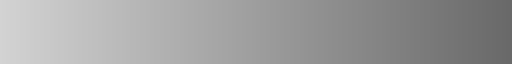

In [60]:
cmap_color_ROHR='DI'
norm_min_ROHR=gdf_ROHR[cmap_color_ROHR].min()
norm_max_ROHR=gdf_ROHR[cmap_color_ROHR].max()
norm_ROHR_color = plt.Normalize(vmin=norm_min_ROHR, vmax=norm_max_ROHR)
colors_ROHR = ['lightgray', 'dimgray']
cmap_ROHR = matplotlib.colors.LinearSegmentedColormap.from_list('ROHR', colors_ROHR, N = 256)
cmap_ROHR

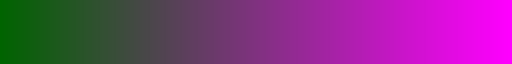

In [61]:
cmap_color_ROHRErg='QMAVAbs'
norm_min_ROHRErg=gdf_ROHR[cmap_color_ROHRErg].min()
norm_max_ROHRErg=gdf_ROHR[cmap_color_ROHRErg].max()
norm_ROHRErg_color = plt.Normalize(vmin=norm_min_ROHRErg, vmax=norm_max_ROHRErg)
colors_ROHRErg = ['darkgreen','magenta']
cmap_ROHRErg = matplotlib.colors.LinearSegmentedColormap.from_list('ROHRErg', colors_ROHRErg, N = 256)
cmap_ROHRErg

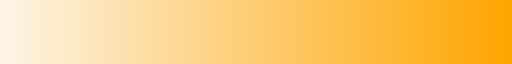

In [62]:
cmap_color_FWVB='W'
norm_min_FWVB=gdf_FWVB[gdf_FWVB['NAME_CONT'].isin(['M-1-0-1'])][cmap_color_FWVB].min()
norm_max_FWVB=gdf_FWVB[gdf_FWVB['NAME_CONT'].isin(['M-1-0-1'])][cmap_color_FWVB].max()
norm_FWVB_color = plt.Normalize(vmin=norm_min_FWVB, vmax=norm_max_FWVB)
colors_FWVB = ['oldlace', 'orange']
cmap_FWVB = matplotlib.colors.LinearSegmentedColormap.from_list('FWVB', colors_FWVB, N = 256)
cmap_FWVB

In [63]:
cmap_ROHRFac=0.0125*1.5 
cmap_FWVBFac=0.0125

In [64]:
ma=gdf_FWVB[gdf_FWVB['NAME_CONT'].isin(['M-1-0-1'])].loc[:,['W','geometry']].sort_values(by=['W'],ascending=False).explore(
style_kwds=dict(
    style_function=                                 
            lambda x: {                 
                 'weight': x['properties']['W']*cmap_FWVBFac
                ,'color':  matplotlib.colors.to_hex(cmap_FWVB(norm_FWVB_color(x['properties']['W'])))     
                       }                     
             ),  
    marker_kwds=dict(#radius=0.25,
                     fill=False
                    ,color='black'
                    ),
    marker_type="circle_marker",    
) 

m2=gdf_ROHR[gdf_ROHR['KVR'].isin([1])].loc[:,['DI','geometry']].sort_values(by=['DI'],ascending=True).explore(
m=ma,
style_kwds=dict(
    style_function=                                 
            lambda x: {                 
                 'weight': x['properties']['DI']*cmap_ROHRFac
                ,'color':  matplotlib.colors.to_hex(cmap_ROHR(norm_ROHR_color(x['properties']['DI'])))     
                       }                     
             ),                           
) 
gdf_ROHR[gdf_ROHR['KVR'].isin([1])].loc[:,[cmap_color_ROHRErg,'geometry']].sort_values(by=[cmap_color_ROHRErg],ascending=True).explore(
m=m2,
style_kwds=dict(
    style_function=                                 
            lambda x: {                 
                 'weight': x['properties'][cmap_color_ROHRErg]*cmap_ROHRFac
                ,'color':  matplotlib.colors.to_hex(cmap_ROHRErg(norm_ROHRErg_color(x['properties'][cmap_color_ROHRErg])))     
                       }                     
             ),                           
) 



In [65]:
# wenn man Karten-interaktiv arbeiten will sollte man zu QGIS gehen
# Skripting wie gezeigt hat seine Stärken in der generierenden Analyse und der Generierung von Reports
# nicht nur NFDs sondern auch Zeitkurven, Längsschnitte und Kombis der Darstellungsformen auf einem (PDF-)Blatt oder in einem PDF-Buch

# dank der transparenten Datenstruktur von SIR 3S kann ja jede Anwenderin außerhalb von SIR 3S nehmen was sie will ...

# NFD-Report

In [66]:
try:
    from PT3S import Rm
except:
    import Rm

In [67]:
# von wo wurde geladen ...
importlib.reload(Rm)

<module 'Rm' from 'c:\\users\\wolters\\3s\\pt3s\\Rm.py'>

In [68]:
try:
    from PT3S import pNFD
except:
    import pNFD

In [69]:
# von wo wurde geladen ...
importlib.reload(pNFD)

<module 'pNFD' from 'c:\\users\\wolters\\3s\\pt3s\\pNFD.py'>

In [70]:
#gdf_ROHR.columns.to_list()

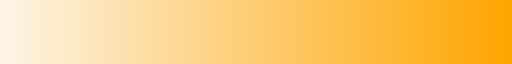

In [71]:
cmap_color_ROHR='DI'
norm_min_ROHR=gdf_ROHR[cmap_color_ROHR].min()
norm_max_ROHR=gdf_ROHR[cmap_color_ROHR].max()
norm_ROHR_color = plt.Normalize(vmin=norm_min_ROHR, vmax=norm_max_ROHR)
colors_ROHR = ['oldlace', 'orange']
cmap_ROHR2 = matplotlib.colors.LinearSegmentedColormap.from_list('ROHR', colors_ROHR, N = 256)
cmap_ROHR2

## plotLogo

In [72]:
def plotLogo(axSrc
        ,dfSrc
        ,logoFile=r"C:\Users\wolters\3S\HuM\SimKI-Mop\trunk\Bad Salzuflen\Version 1\SimKI-Mop Logo.png"
        ,dxAxesLogo=.125
       ,leftLogo=.875
       ,bottomLogo=.025
       ,dxAxesBlocksyms=.125*0.25
        ):
        
    import matplotlib.pyplot as plt
    import numpy as np
    from PIL import Image
    
    # Logo SimKI ###################
    img = np.asarray(Image.open(logoFile))
    dxIm=1266#1800.
    dyIm=1244#1698.
    
    dyAxesLogo=dyIm/dxIm*dxAxesLogo
    
    import matplotlib
    ax= plt.axes([leftLogo,bottomLogo, dxAxesLogo, dyAxesLogo])    
    ax.imshow(img,aspect='equal',alpha=.5)
    ax.axis('off')
        
    # Logo Blocksymbole #############################
    erzFile=r"C:\Users\wolters\3S\HuM\SimKI-Mop\trunk\Bad Salzuflen\Version 1\bhkw.png"
    img = np.asarray(Image.open(erzFile))
    
    dxIm=186
    dyIm=148
    
    dyAxesBlocksyms=dyIm/dxIm*dxAxesBlocksyms
    
    #  Blatt #################
        
    left,right=axSrc.get_xlim()
    bottom,top=axSrc.get_ylim()
    #print(left,right)

    dxSrc=right-left
    dySrc=top-bottom
    
    # Blocksymbole
    
    for index, row in dfSrc.iterrows():
        
        X=row['XKOR']
        Y=row['YKOR']
        XRel=(X-left)/dxSrc - dxAxesBlocksyms/2
        YRel=(Y-bottom)/dySrc - dyAxesBlocksyms/2
        
        ax= plt.axes([XRel
                  ,YRel
                  , dxAxesBlocksyms, dyAxesBlocksyms])    
        ax.imshow(img,aspect='equal',alpha=.5)
        ax.axis('off')         

In [73]:
#gdf_ROHR

In [74]:
dfLAYR[dfLAYR['NAME'].isin(['Verbund Staatsb.-Hoffmann VL'])]['ID'].values

array(['4870748035982946618', '4878733418420130014',
       '4945055245361165910', '5033191389954162115',
       '5164477800331377146', '5233118909283330616',
       '5335466720169583817', '5568476178572848953',
       '5591327965302326575', '5618238991882401958',
       '5625816147006510559'], dtype=object)

In [75]:
 gdf_ROHR_Vb_StaatsHoff = gdf_ROHR[
            gdf_ROHR['tk'].isin(dfLAYR[dfLAYR['NAME'].isin(['Verbund Staatsb.-Hoffmann VL'])]['ID'].values)
        ]#.sort_values(by=['DI'],ascending=True)    

In [76]:
gdf_ROHR_Vb_StaatsHoff2 = gdf_ROHR[
            gdf_ROHR['tk'].isin(dfLAYR[dfLAYR['NAME'].isin(['Verbund Staatsb.-Hoffmann 2 VL'])]['ID'].values)
        ]#.sort_values(by=['DI'],ascending=True)  

In [77]:
gdf_ROHR_Vb_ZiegelStaats = gdf_ROHR[
            gdf_ROHR['tk'].isin(dfLAYR[dfLAYR['NAME'].isin(['Verbund ZiegelStaatsb. VL'])]['ID'].values)
        ]#.sort_values(by=['DI'],ascending=True)  

In [78]:
gdf_ROHR_Vb=pd.concat([gdf_ROHR_Vb_StaatsHoff,gdf_ROHR_Vb_StaatsHoff2,gdf_ROHR_Vb_ZiegelStaats]).sort_values(by=['DI'],ascending=True)  

In [79]:
gdf_ROHR_Vb['DI'].describe()

count     17.000000
mean     225.658828
std       24.845446
min      210.100006
25%      210.100006
50%      210.100006
75%      263.000000
max      263.000000
Name: DI, dtype: float64

In [80]:
gdf_ROHR_Vb.shape

(17, 178)

In [81]:
# von wo wurde geladen ...
importlib.reload(pNFD)

<module 'pNFD' from 'c:\\users\\wolters\\3s\\pt3s\\pNFD.py'>

In [82]:
#gdf_FWVB.columns.to_list()

## plot

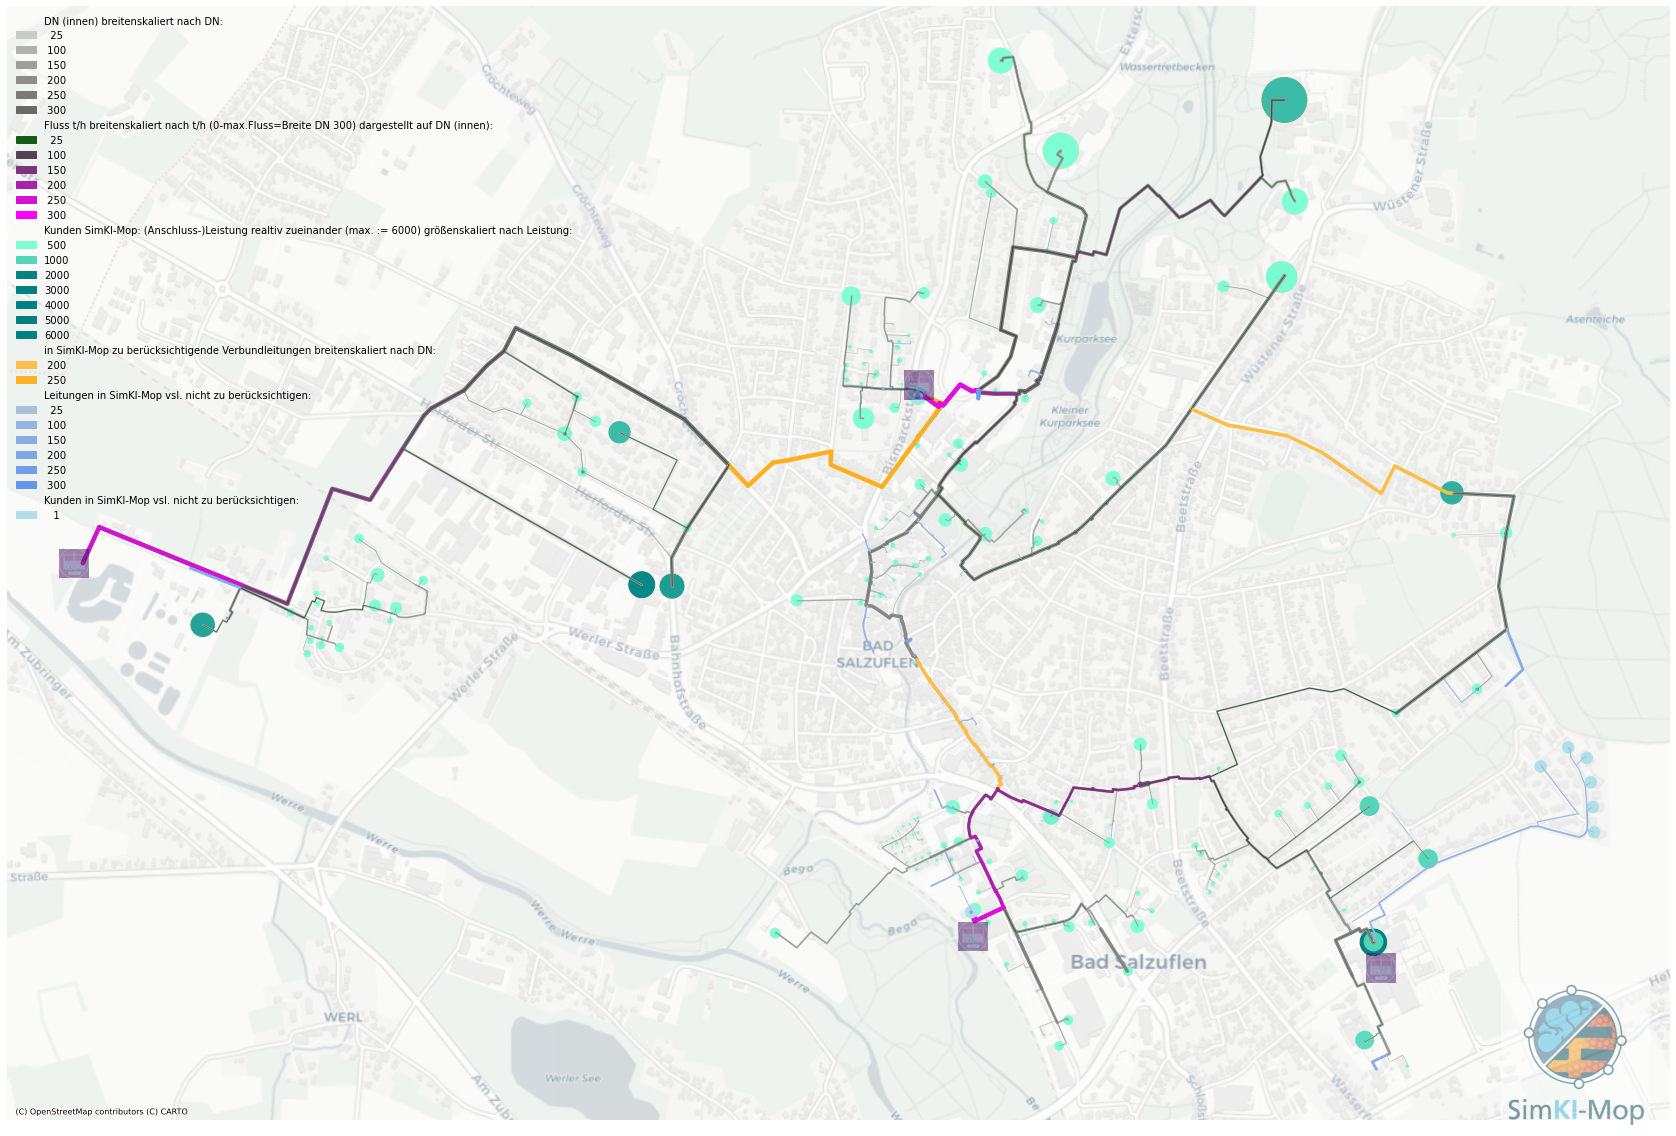

In [83]:
# Plotten
fig=plt.figure(figsize=Rm.DINA2q,dpi=Rm.dpiSize)

ax=fig.gca()

attr_colors_ROHR_Sach_patches,attr_colors_ROHR_Erg_patches,attr_colors_FWVB_Sach_patches,attr_colors_FWVB_Erg_patches,dummy=pNFD.pNFD_FW(
        ax=ax,
    
        # ROHR
        gdf_ROHR = gdf_ROHR[            
            (gdf_ROHR['KVR'].isin([1]))
            &
            (gdf_ROHR['QMAVAbs']>0.10)
        ].sort_values(by=['DI'],ascending=True)    
    
       ,norm_min_ROHR_Sach=0    
       ,norm_max_ROHR_Sach=300
       ,attr_colors_ROHR_Sach_patches_fmt="{:4.0f}"
       ,attr_colors_ROHR_Sach_patchValues=[25,100,150,200,250,300]
    
       ,attr_colors_ROHR_Erg='QMAVAbs'
       ,lws_ROHR_Erg_Sach=False    
       ,norm_max_ROHR_Erg=300
       ,attr_colors_ROHR_Erg_patches_fmt="{:4.0f}"   
       ,attr_colors_ROHR_Erg_patchValues=[25,100,150,200,250,300]
        
        # FWVB
       ,gdf_FWVB = gdf_FWVB[
           gdf_FWVB['NAME_CONT'].isin(['M-1-0-1'])
           &
           gdf_FWVB['W0']>0.01       
       ].sort_values(by=['W'],ascending=False)       
       ,attr_colors_FWVB_Erg='W'
       ,norm_min_FWVB_Erg = 500 
       ,attr_colors_FWVB_Erg_patchValues= [500,1000,2000,3000,4000,5000,6000]
       ,attr_colors_FWVB_Erg_patches_fmt="{:4.0f}"     
    
       ,MapOn=False
           
       )


attr_colors_ROHR_Sach_patchesVb,dummy,dummy,dummy,dummy=pNFD.pNFD_FW(
        ax=ax,
    
        gdf_ROHR = gdf_ROHR_Vb.sort_values(by=['DI'],ascending=True)    
    
       ,attr_colors_ROHR_Erg=None
       ,norm_min_ROHR_Sach=0    
       ,norm_max_ROHR_Sach=300    
       ,colors_ROHR_Sach = ['oldlace', 'orange']
       ,attr_colors_ROHR_Sach_patches_fmt="{:4.0f}"
       ,attr_colors_ROHR_Sach_patchValues=[200,250]    
    
       ,MapOn=False       
       )

attr_colors_ROHR_Sach_patchesX,dummy,attr_colors_FWVB_Sach_patchesX,dummy,dummy=pNFD.pNFD_FW(
        ax=ax,
    
        gdf_ROHR = gdf_ROHR [            
            (gdf_ROHR['KVR'].isin([1]))
            &
            ~(gdf_ROHR['QMAVAbs']>0.10)
            &
            ~(gdf_ROHR['tk'].isin(gdf_ROHR_Vb['tk'].values))
            &            
            ~(gdf_ROHR['tk'].isin(dfLAYR[dfLAYR['NAME'].isin(['Verbund ZiegelStaatsb. 2 VL'])]['ID'].values))            
        ].sort_values(by=['DI'],ascending=True)    
    
       ,attr_colors_ROHR_Erg=None
       ,norm_min_ROHR_Sach=0    
       ,norm_max_ROHR_Sach=300    
       ,colors_ROHR_Sach = ['lightsteelblue', 'cornflowerblue']
       ,attr_colors_ROHR_Sach_zOrder=6
       ,attr_colors_ROHR_Sach_patches_fmt="{:4.0f}"
       ,attr_colors_ROHR_Sach_patchValues=[25,100,150,200,250,300]
      # ,attr_colors_ROHR_Sach_patchValues=[200,250]    
    
        # FWVB
       ,gdf_FWVB = gdf_FWVB[
           (gdf_FWVB['NAME_CONT'].isin(['M-1-0-1']))
           &
           ~(gdf_FWVB['W0']>0.01)       
       ]#.sort_values(by=['W0'],ascending=False)       
       ,attr_colors_FWVB_Sach='dummy'
       ,attr_colors_FWVB_Sach_zOrder=5
       ,attr_ms_FWVB_Sach='dummy' 
       ,colors_FWVB_Sach = ['lavender', 'powderblue'] 
       #,norm_min_FWVB_Sach=0.9    
       #,norm_max_FWVB_Sach=1.1    
       ,fac_ms_FWVB=8000./15
       #,norm_min_FWVB_Erg = 0 
       ,attr_colors_FWVB_Sach_patchValues= [1]
       ,attr_colors_FWVB_Sach_patches_fmt="{:4.0f}"         
    
       ,MapOn=False  
       )

trenn_patchDNIst = mpatches.Patch(color='white', label='DN (innen) breitenskaliert nach DN:',alpha=.01)
trenn_patchQIst = mpatches.Patch(color='white', label='Fluss t/h breitenskaliert nach t/h (0-max.Fluss=Breite DN 300) dargestellt auf DN (innen):',alpha=.01)
trenn_patchW = mpatches.Patch(color='white', label='Kunden SimKI-Mop: (Anschluss-)Leistung realtiv zueinander (max. := 6000) größenskaliert nach Leistung:',alpha=.01)
trenn_patchDN = mpatches.Patch(color='white', label='in SimKI-Mop zu berücksichtigende Verbundleitungen breitenskaliert nach DN:',alpha=.01)

trenn_attr_colors_ROHR_Sach_patchesX=mpatches.Patch(color='white', label='Leitungen in SimKI-Mop vsl. nicht zu berücksichtigen:',alpha=.01)
trenn_attr_colors_FWVB_Sach_patchesX=mpatches.Patch(color='white', label='Kunden in SimKI-Mop vsl. nicht zu berücksichtigen:',alpha=.01)

ax.legend(handles=
              
              [trenn_patchDNIst]+attr_colors_ROHR_Sach_patches
             +[trenn_patchQIst]+attr_colors_ROHR_Erg_patches
             +[trenn_patchW]+attr_colors_FWVB_Erg_patches
             +[trenn_patchDN]+attr_colors_ROHR_Sach_patchesVb
             +[trenn_attr_colors_ROHR_Sach_patchesX]+attr_colors_ROHR_Sach_patchesX
             +[trenn_attr_colors_FWVB_Sach_patchesX]+attr_colors_FWVB_Sach_patchesX
#             +[trenn_patchW]+attr_colors_FWVB_Erg_patches2
             ,loc='upper left'
             ,facecolor='white', framealpha=.01)


plotLogo(ax
,V3_KNOT[~pd.isnull(V3_KNOT['NAME_CONT_VKNO'])][['NAME_CONT_VKNO'
                                               # ,'NAME'
                                                ,'XKOR','YKOR']].groupby(by=['NAME_CONT_VKNO']).mean())

import contextily as cx
cx.add_basemap(ax, crs=gdf_ROHR.crs.to_string(), source = cx.providers.CartoDB.Positron, zoom = 15)

plt.tight_layout() 

plt.savefig('NFDBsp.pdf',dpi=2*Rm.dpiSize)
plt.savefig('NFDBsp.png',dpi=2*Rm.dpiSize)

In [84]:
axAlt=ax
axAlt.get_xlim()

(480395.2206795, 484577.10301049997)

## plot mit WBilanzen

In [85]:
sorted([col for col in mx.df if re.search('^WBLZ',col)])

['WBLZ~G2Staats~~5196639304551047703~WES']

In [86]:
tMaxG2=mx.df['WBLZ~G2Staats~~5196639304551047703~WES'].idxmax().tz_convert(None)+pd.Timedelta('1 hour')


In [87]:
G2StaatsNodeIDs=dfWBLZ[dfWBLZ['NAME'].isin(['G2Staats'])]['ID'].values

In [88]:
gdf_ROHR_G2Staats = gdf_ROHR[
            (gdf_ROHR['fkKI'].isin(G2StaatsNodeIDs))
            &
            (gdf_ROHR['fkKK'].isin(G2StaatsNodeIDs))
            &
            (gdf_ROHR['QMAVAbs']>0.10)
            &
            (gdf_ROHR['KVR'].isin([1]))
]

In [89]:
gdf_FWVB_G2Staats = gdf_FWVB[
            (gdf_FWVB['fkKI'].isin(G2StaatsNodeIDs))
            &
            (gdf_FWVB['fkKK'].isin(G2StaatsNodeIDs))
            &
            (gdf_FWVB['NAME_CONT'].isin(['M-1-0-1']))
            &
            (gdf_FWVB['W0']>0.01)
]

In [90]:
G1HoffLohNodeIDs=dfWBLZ[dfWBLZ['NAME'].isin(['G1HoffLoh'])]['ID'].values

In [91]:
gdf_ROHR_G1HoffLoh = gdf_ROHR[
            (gdf_ROHR['fkKI'].isin(G1HoffLohNodeIDs))
            &
            (gdf_ROHR['fkKK'].isin(G1HoffLohNodeIDs))
            &
            (gdf_ROHR['QMAVAbs']>0.10)
            &
            (gdf_ROHR['KVR'].isin([1]))
]

In [92]:
gdf_FWVB_G1HoffLoh = gdf_FWVB[
            (gdf_FWVB['fkKI'].isin(G1HoffLohNodeIDs))
            &
            (gdf_FWVB['fkKK'].isin(G1HoffLohNodeIDs))
            &
            (gdf_FWVB['NAME_CONT'].isin(['M-1-0-1']))
            &
            (gdf_FWVB['W0']>0.01)
]

In [93]:
G3ZiegelNodeIDs=dfWBLZ[dfWBLZ['NAME'].isin(['G3Ziegel'])]['ID'].values

In [94]:
gdf_ROHR_G3Ziegel = gdf_ROHR[
            (gdf_ROHR['fkKI'].isin(G3ZiegelNodeIDs))
            &
            (gdf_ROHR['fkKK'].isin(G3ZiegelNodeIDs))
            &
            (gdf_ROHR['QMAVAbs']>0.10)
            &
            (gdf_ROHR['KVR'].isin([1]))
]

In [95]:
gdf_FWVB_G3Ziegel = gdf_FWVB[
            (gdf_FWVB['fkKI'].isin(G3ZiegelNodeIDs))
            &
            (gdf_FWVB['fkKK'].isin(G3ZiegelNodeIDs))
            &
            (gdf_FWVB['NAME_CONT'].isin(['M-1-0-1']))
            &
            (gdf_FWVB['W0']>0.01)
]

In [96]:
tA=pd.Timestamp(mx.df.index[0].strftime('%Y-%m-%d %X.%f'))
tE=pd.Timestamp(mx.df.index[-1].strftime('%Y-%m-%d %X.%f'))

In [97]:
idxWES=('TMAX','WBLZ~*~*~*~WES',tA,tE)
idxWVB=('TMAX','WBLZ~*~*~*~WVB',tA,tE)
#idxWVERL=('TMAX','WBLZ~*~*~*~WVERL',tA,tE)

In [98]:
m.V3_WBLZ#[m.V3_WBLZ['NAME']=='G2Staats']

pk                 fkDE                   rk                   tk                    BESCHREIBUNG          NAME           TYP  AKTIV  IDIM (STAT, WBLZ~*~*~*~WES, 2022-12-16 02:00:00, 2022-12-16 02:00:00) (TIME, WBLZ~*~*~*~WES, 2022-12-16 02:00:00, 2022-12-16 02:00:00) (TMIN, WBLZ~*~*~*~WES, 2022-12-16 02:00:00, 2022-12-17 02:00:00) (TMAX, WBLZ~*~*~*~WES, 2022-12-16 02:00:00, 2022-12-17 02:00:00) (STAT, WBLZ~*~*~*~WRAND, 2022-12-16 02:00:00, 2022-12-16 02:00:00) (TIME, WBLZ~*~*~*~WRAND, 2022-12-16 02:00:00, 2022-12-16 02:00:00) (TMIN, WBLZ~*~*~*~WRAND, 2022-12-16 02:00:00, 2022-12-17 02:00:00) (TMAX, WBLZ~*~*~*~WRAND, 2022-12-16 02:00:00, 2022-12-17 02:00:00) (STAT, WBLZ~*~*~*~WSPEI, 2022-12-16 02:00:00, 2022-12-16 02:00:00) (TIME, WBLZ~*~*~*~WSPEI, 2022-12-16 02:00:00, 2022-12-16 02:00:00) (TMIN, WBLZ~*~*~*~WSPEI, 2022-12-16 02:00:00, 2022-12-17 02:00:00) (TMAX, WBLZ~*~*~*~WSPEI, 2022-12-16 02:00:00, 2022-12-17 02:00:00) (STAT, WBLZ~*~*~*~WVB, 2022-12-16 02:00:00, 2022-12-16 02:00:00) (TIME, WBLZ~*~*~*~WVB, 2022-12-16 02:00:00, 2022-12-16 02:00:00) (TMIN, WBLZ~*~*~*~WVB, 2022-12-16 02:00:00, 2022-12-17 02:00:00) (TMAX, WBLZ~*~*~*~WVB, 2022-12-16 02:00:00, 2022-12-17 02:00:00) (STAT, WBLZ~*~*~*~WVERL, 2022-12-16 02:00:00, 2022-12-16 02:00:00) (TIME, WBLZ~*~*~*~WVERL, 2022-12-16 02:00:00, 2022-12-16 02:00:00) (TMIN, WBLZ~*~*~*~WVERL, 2022-12-16 02:00:00, 2022-12-17 02:00:00) (TMAX, WBLZ~*~*~*~WVERL, 2022-12-16 02:00:00, 2022-12-17 02:00:00)
1  5405432883122453358  5548498001897419184  5405432883122453358  5405432883122453358  Wärmebilanz für das Gesamtnetz  WärmeblnzGes  WAERMEBILANZ    1.0   1.0                                                        35.034149                                                        33.983944                                                        33.565189                                                        36.753963                                                          -0.006042                                                           -0.00634                                                          -0.008066                                                          -0.001445                                                           0.095964                                                          -0.991421                                                          -1.776633                                                           0.095964                                                        32.228199                                                        32.245995                                                        32.218719                                                        35.501442                                                           2.703944                                                           2.723031                                                           2.703944                                                           2.732803
2  5573377163067291142  5548498001897419184  5573377163067291142  5573377163067291142                     Wärmebilanz     G1HoffLoh  WAERMEBILANZ    1.0   1.0                                                        17.073811                                                        16.539957                                                        16.407351                                                        17.073811                                                          -0.005647                                                          -0.003839                                                          -0.005647                                                          -0.000666                                                          -0.009542                                                          -0.549503                                                          -0.685716                                                          -0.009542                                                        15.983237                                   

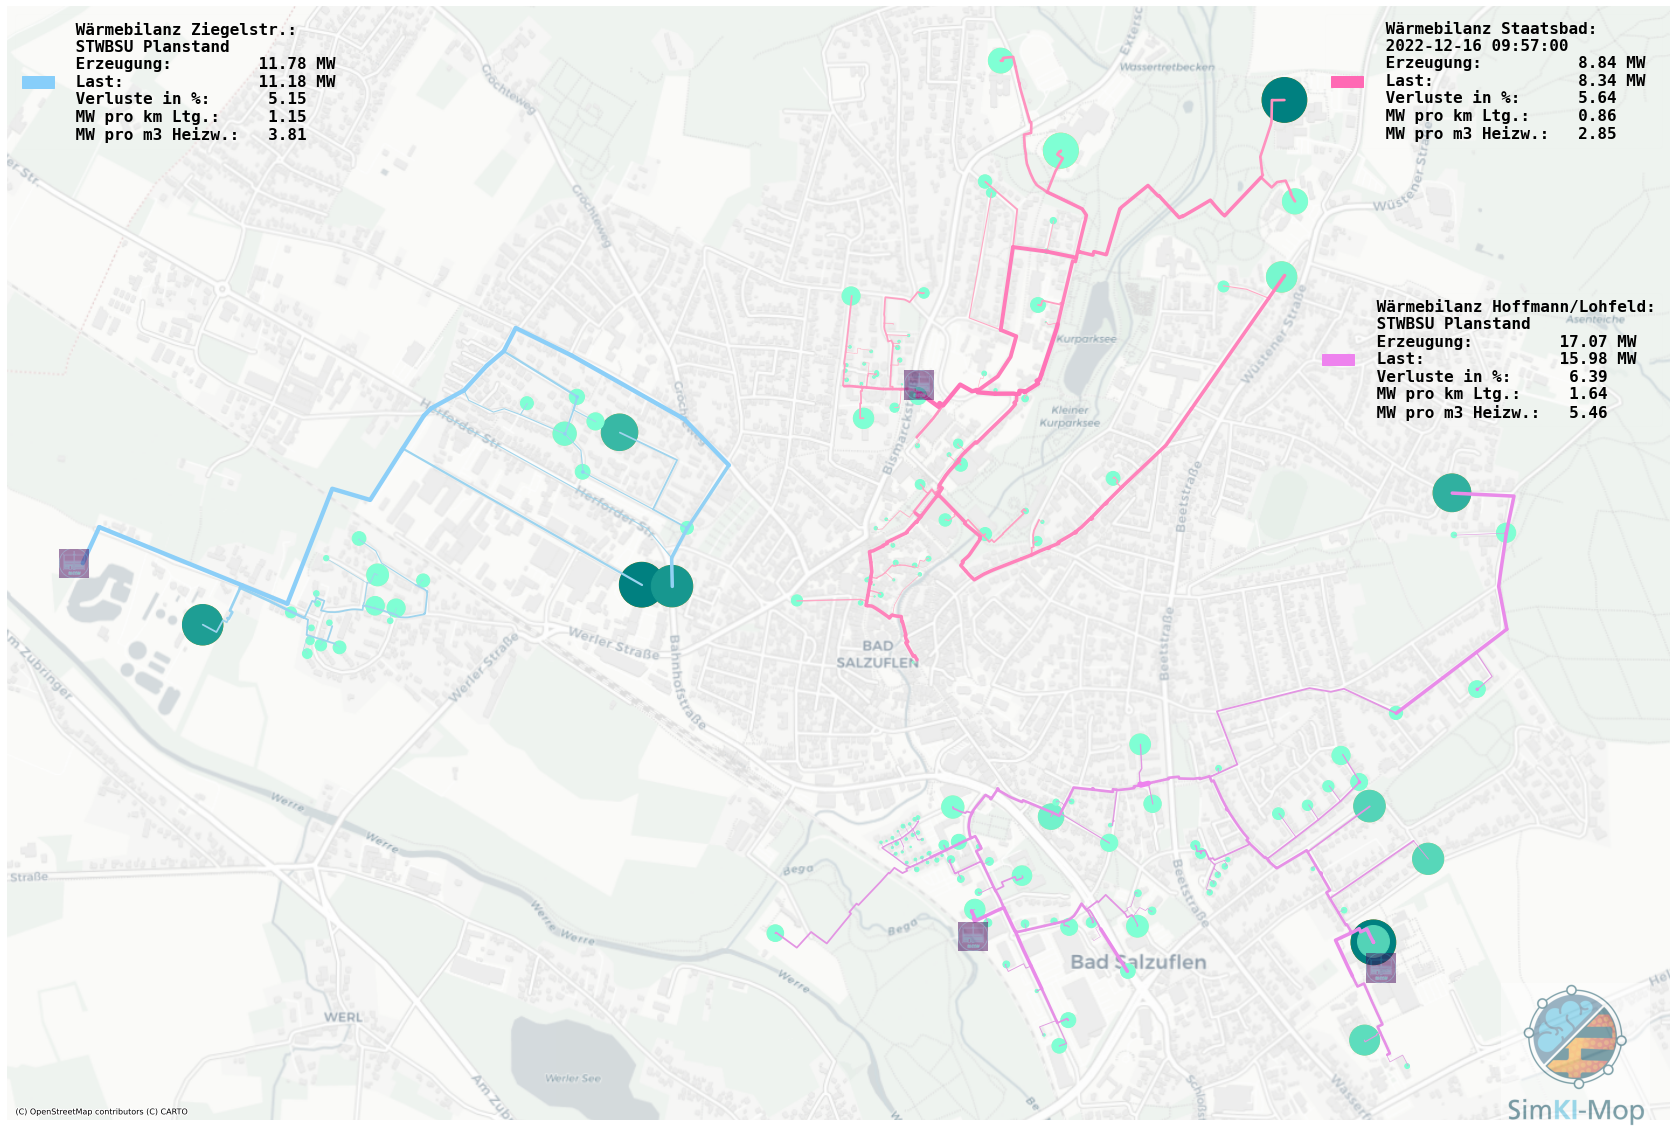

In [99]:
# Plotten
fig=plt.figure(figsize=Rm.DINA2q,dpi=Rm.dpiSize)

ax=fig.gca()

for gdfR,gdfF,cm in zip([gdf_ROHR_G2Staats,gdf_ROHR_G1HoffLoh,gdf_ROHR_G3Ziegel],[gdf_FWVB_G2Staats,gdf_FWVB_G1HoffLoh,gdf_FWVB_G3Ziegel],[['pink', 'hotpink'],['plum', 'violet'],['lightblue', 'lightskyblue']]):
            attr_colors_ROHR_Sach_patches,attr_colors_ROHR_Erg_patches,attr_colors_FWVB_Sach_patches,attr_colors_FWVB_Erg_patches,dummy=pNFD.pNFD_FW(
                    ax=ax

  
            # ROHR
           ,gdf_ROHR = gdfR.sort_values(by=['DI'],ascending=True)   # kleine zuerst (große ueber kleine)  

           ,attr_colors_ROHR_Erg=None
           ,norm_min_ROHR_Sach=0    
           ,norm_max_ROHR_Sach=300    
           ,colors_ROHR_Sach = cm#['pink', 'hotpink']
           ,attr_colors_ROHR_Sach_patches_fmt="{:4.0f}"
           ,attr_colors_ROHR_Sach_patchValues=[25,100,150,200,250,300]        
            # FWVB
           ,gdf_FWVB = gdfF.sort_values(by=['W'],ascending=False) # große zuerst (kleine ueber große)       
           ,attr_colors_FWVB_Erg='W'
           ,norm_min_FWVB_Erg = 500 
           ,attr_colors_FWVB_Erg_patches_fmt="{:4.0f}" 
           ,attr_colors_FWVB_Erg_patchValues= [500,1000,2000,3000,4000,5000,6000]       
    
           ,MapOn=False 

           )

s=m.V3_WBLZ[m.V3_WBLZ['NAME']=='G2Staats'].iloc[0]
patchG2Staats = mpatches.Patch(color='hotpink', label=' Wärmebilanz Staatsbad:\n {tMax:s}\n {WESTxt:s} {WES:5.2f} MW \n {WVBTxt:s} {WVB:5.2f} MW \n {WVERLTxt:s} {WVERL:5.2f}\n {WpKmTxt:s} {WpKm:5.2f} \n {WpVolTxt:s} {WpVol:5.2f}'.format(
                                                                                                                                               tMax=str(tMaxG2)  
                                                                                                                                              ,WES=s[idxWES]
                                                                                                                                              ,WVB=s[idxWVB]
                                                                                                                                              ,WVERL=(s[idxWES]-s[idxWVB])/s[idxWES]*100
                                                                                                                                              ,WpKm=s[idxWVB]/(gdf_ROHR_G2Staats['L'].sum()/1000)
                                                                                                                                              ,WpVol=s[idxWVB]/(gdf_ROHR_G2Staats['V'].sum())
                                                                                                                                              ,WESTxt='Erzeugung:'.ljust(18)
                                                                                                                                              ,WVBTxt='Last:'.ljust(18)
                                                                                                                                              ,WVERLTxt='Verluste in %:'.ljust(18)
                                                                                                                                              ,WpKmTxt='MW pro km Ltg.:'.ljust(18)
                                                                                                                                              ,WpVolTxt='MW pro m3 Heizw.:'.ljust(18)
                                                                                                                                              )                              
                              )
s=m.V3_WBLZ[m.V3_WBLZ['NAME']=='G1HoffLoh'].iloc[0]
patchG1HoffLoh = mpatches.Patch(color='violet', label=' Wärmebilanz Hoffmann/Lohfeld:\n STWBSU Planstand\n {WESTxt:s} {WES:5.2f} MW \n {WVBTxt:s} {WVB:5.2f} MW \n {WVERLTxt:s} {WVERL:5.2f}\n {WpKmTxt:s} {WpKm:5.2f} \n {WpVolTxt:s} {WpVol:5.2f}'.format(
                                                                                                                                               tMax=str(tMaxG2)  
                                                                                                                                              ,WES=s[idxWES]
                                                                                                                                              ,WVB=s[idxWVB]
                                                                                                                                              ,WVERL=(s[idxWES]-s[idxWVB])/s[idxWES]*100
                                                                                                                                              ,WpKm=s[idxWVB]/(gdf_ROHR_G2Staats['L'].sum()/1000)
                                                                                                                                              ,WpVol=s[idxWVB]/(gdf_ROHR_G2Staats['V'].sum())
                                                                                                                                              ,WESTxt='Erzeugung:'.ljust(18)
                                                                                                                                              ,WVBTxt='Last:'.ljust(18)
                                                                                                                                              ,WVERLTxt='Verluste in %:'.ljust(18)
                                                                                                                                              ,WpKmTxt='MW pro km Ltg.:'.ljust(18)
                                                                                                                                              ,WpVolTxt='MW pro m3 Heizw.:'.ljust(18)
                                                                                                                                              )                              
                              )

s=m.V3_WBLZ[m.V3_WBLZ['NAME']=='G3Ziegel'].iloc[0]
patchG3Ziegel  = mpatches.Patch(color='lightskyblue', label=' Wärmebilanz Ziegelstr.:\n STWBSU Planstand\n {WESTxt:s} {WES:5.2f} MW \n {WVBTxt:s} {WVB:5.2f} MW \n {WVERLTxt:s} {WVERL:5.2f}\n {WpKmTxt:s} {WpKm:5.2f} \n {WpVolTxt:s} {WpVol:5.2f}'.format(
                                                                                                                                               tMax=str(tMaxG2)  
                                                                                                                                              ,WES=s[idxWES]
                                                                                                                                              ,WVB=s[idxWVB]
                                                                                                                                              ,WVERL=(s[idxWES]-s[idxWVB])/s[idxWES]*100
                                                                                                                                              ,WpKm=s[idxWVB]/(gdf_ROHR_G2Staats['L'].sum()/1000)
                                                                                                                                              ,WpVol=s[idxWVB]/(gdf_ROHR_G2Staats['V'].sum())
                                                                                                                                              ,WESTxt='Erzeugung:'.ljust(18)
                                                                                                                                              ,WVBTxt='Last:'.ljust(18)
                                                                                                                                              ,WVERLTxt='Verluste in %:'.ljust(18)
                                                                                                                                              ,WpKmTxt='MW pro km Ltg.:'.ljust(18)
                                                                                                                                              ,WpVolTxt='MW pro m3 Heizw.:'.ljust(18)
                                                                                                                                              )                              
                              )

import matplotlib.font_manager as font_manager
font = font_manager.FontProperties(family='monospace',
                                   weight='bold',
                                   style='normal', size=16)

G2StaatsL=ax.legend(handles=              
              [patchG2Staats]          
             ,loc='upper right'
          #   ,facecolor='white'
          ,prop=font
          , framealpha=.01)


G1HoffLohL=ax.legend(handles=              
              [patchG1HoffLoh]          
             ,loc='upper right'
             ,bbox_to_anchor=(0.5, 0., 0.5, 0.75)
          #   ,facecolor='white'
          ,prop=font
          , framealpha=.01)

G3ZiegelL=ax.legend(handles=              
              [patchG3Ziegel]          
             ,loc='upper left'
          #   ,facecolor='white'
          ,prop=font
          , framealpha=.01)




from matplotlib import pyplot
pyplot.gca().add_artist(G2StaatsL)
pyplot.gca().add_artist(G1HoffLohL)

ax.set_xlim(axAlt.get_xlim())
ax.set_ylim(axAlt.get_ylim())

plotLogo(ax
,V3_KNOT[~pd.isnull(V3_KNOT['NAME_CONT_VKNO'])][['NAME_CONT_VKNO'
                                               # ,'NAME'
                                                ,'XKOR','YKOR']].groupby(by=['NAME_CONT_VKNO']).mean())



import contextily as cx
cx.add_basemap(ax, crs=gdf_ROHR.crs.to_string(), source = cx.providers.CartoDB.Positron, zoom = 15)

plt.tight_layout() 

plt.savefig('NFDBspMitWblz.pdf',dpi=2*Rm.dpiSize)
plt.savefig('NFDBspMitWblz.png',dpi=2*Rm.dpiSize)

# Test

In [100]:
dfLAYR.head()

pk                   tk  LFDNR          NAME  AnzDerObjekteInGruppe  AnzDerObjekteDesTypsInGruppe  TYPE                   ID  NrDesObjektesDesTypsInGruppe  NrDesObjektesInGruppe  GruppenDesObjektsAnz            GruppenDesObjektsNamen
0  4615316810435331673  4615316810435331673    1.0  Blocksymbole                      4                             4  CONT  4825472149394202907                             1                      1                     2  [Blocksymbole, Gebiet 1 HoffLoh]
1  4615316810435331673  4615316810435331673    1.0  Blocksymbole                      4                             4  CONT  5312839466984016002                             2                      2                     2  [Blocksymbole, Gebiet 1 HoffLoh]
2  4615316810435331673  4615316810435331673    1.0  Blocksymbole                      4                             4  CONT  5483797063333391933                             3                      3                     2   [Blocksymbole, Gebiet 2 Staats]
3  4615316810435331673  4615316810435331673    1.0  Blocksymbole                      4                             4  CONT  5603411125000654144                             4                      4                     2   [Blocksymbole, Gebiet 3 Ziegel]
4  5037484777939939678  5037484777939939678    2.0   BlockKreise                      4                             4  CIRC  4854559580991530594                             1                      1                     1                     [BlockKreise]

In [101]:
s="KNOT~123\t".encode('utf-8')+"KNOT~456\t".encode('utf-8')  
s

b'KNOT~123\tKNOT~456\t'

In [102]:
s.decode('utf-8').split('\t')

['KNOT~123', 'KNOT~456', '']